target_native_gates = ['Hadamard','RX','RY','RZ','CNOT']

In [14]:
import pennylane as qml
from qco_spec_table import show_circuit, comp_table, comp_table_runtime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
[ds] = qml.data.load("ketgpt")

In [4]:
# example
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

comp_table(circuit)

,Original,Qiskit,PennyLane,Our approach
Gate count,141,37,38,31
Single-qubit gate count,116,18,19,12
Two-qubit gate count,25,19,19,19
Circuit depth,32,16,16,12


In [5]:
comp_table_runtime(circuit)

,Original,Qiskit,PennyLane,Our approach
Gate count,141,37.00000,37.00000,31.00000
Single-qubit gate count,116,18.00000,18.00000,12.00000
Two-qubit gate count,25,19.00000,19.00000,19.00000
Circuit depth,32,16.00000,16.00000,12.00000
Runtime,0,0.06347,0.35298,0.13705


In [6]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        df = comp_table(circuit)
        dfs.append(df)
    except:
        pass

In [7]:
len(dfs)                                    

1000

In [9]:
dfs[0]

,Original,Qiskit,PennyLane,Our approach
Gate count,141,37,38,31
Single-qubit gate count,116,18,19,12
Two-qubit gate count,25,19,19,19
Circuit depth,32,16,16,12


In [10]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,PennyLane,Our approach
Gate count,0.262,0.270,0.220
Single-qubit gate count,0.155,0.164,0.103
Two-qubit gate count,0.760,0.760,0.760
Circuit depth,0.500,0.500,0.375


In [15]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

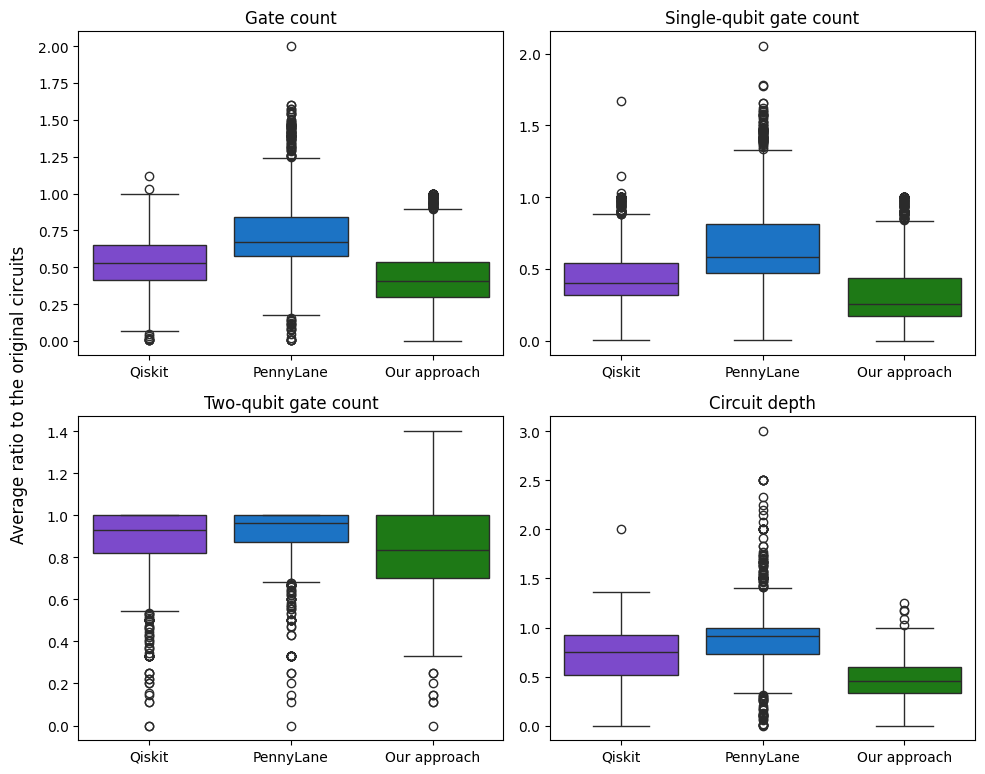

In [16]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8))
for i, metric in enumerate(['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': "#7735E0", 'PennyLane': "#0074E0", 'Our approach': "#108A05"}) # 'Qiskit\n(pattern matching)':'#7b1fb4', 'PennyLane': '#ff7f0e'
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gate count')
    elif i==2:
        ax.set_title('Two-qubit gate count')
    elif i==3:
        ax.set_title('Circuit depth')
    ax.set_xlabel('')
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [17]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,Our approach,Circuit depth,0.483772,0.210466,51.622800
1,Our approach,Gate count,0.447908,0.211033,55.209200
2,Our approach,Single-qubit gate count,0.343096,0.241623,65.690400
3,Our approach,Two-qubit gate count,0.813679,0.175617,18.632086
4,PennyLane,Circuit depth,0.911609,0.344828,8.839100
5,PennyLane,Gate count,0.731665,0.273485,26.833500
6,PennyLane,Single-qubit gate count,0.680085,0.324077,31.991500
7,PennyLane,Two-qubit gate count,0.907309,0.140327,9.269091
8,Qiskit,Circuit depth,0.713375,0.248734,28.662500
9,Qiskit,Gate count,0.543692,0.197151,45.630800


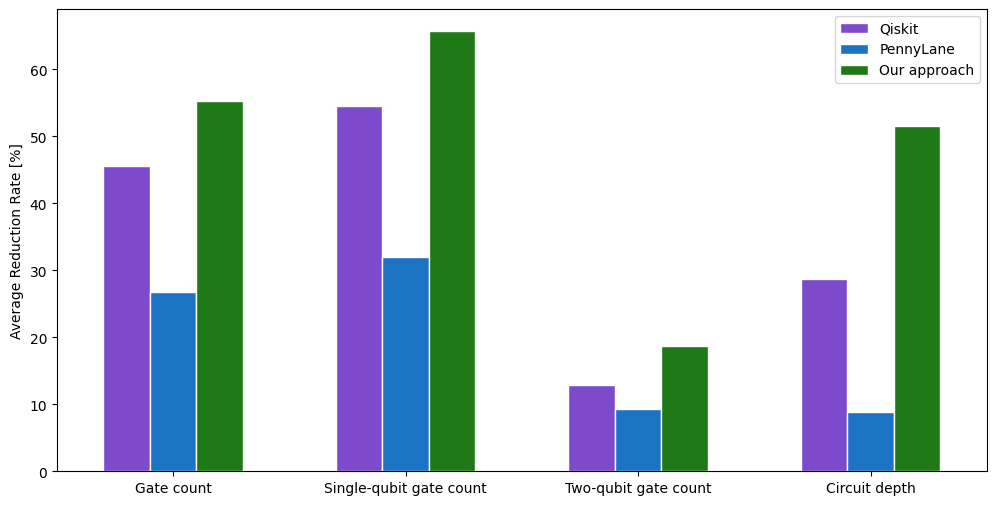

In [18]:
# Drop rows where metric == 'gate types'
df_filtered = mean_df[mean_df["metric"] != "gate types"]

palette = {
    'Qiskit': '#7735E0',
    'PennyLane': '#0074E0',
    'Our approach': '#108A05'
}

method_order = ["Qiskit", "PennyLane", "Our approach"]
metric_order = ['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_filtered,
    x="metric",
    y="mean_percent",
    hue="method",
    hue_order=method_order,
    order=metric_order, 
    palette=palette,
    errorbar="sd",
    width=0.6,
    edgecolor='white'
)

plt.ylabel("Average Reduction Rate [%]")
plt.legend()
plt.xlabel('')
plt.show()